# RFM (Recency, Frequency, Monetary value) cluster analysis

### RMF stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

### Recency: has it been a long time since we've heard from our customers? The accounts that are generating revenue right now are of the most immediate interest to us. Inversely, the customers who haven't made an order in a long time are in need of attention
### Frequency: how often are our customers buying? Our most valuable and reliable customers will be buying on a consistent basis.
### Monetary: on paper, how valuable is each customer? Our dataset records each interaction a customer has had with the company, including orders, returns, cancellations, discounts, etc. We can aggregate the number of total transactions for each customer, as well as sum and mean values for each customer's transactions, to get a glimpse of their net "give and take" impact. Note: we cannot use standard deviation of customer's transaction values because some customers have recorded just one transaction, yielding a meaningless standard deviation of infinite value

### Recency (R) as days since last purchase: How many days ago was their last purchase? Deduct most recent purchase date from today to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?
### Frequency (F) as total number of transactions: How many times has the customer purchased from our store? For example, if someone placed 10 orders over a period of time, their frequency is 10.
### Monetary (M) as total money spent: How many $$ (or whatever is your currency of calculation) has this customer spent? Again limit to last two years – or take all time. Simply total up the money from all transactions to get the M value.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import warnings
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings('ignore')
% matplotlib inline

In [4]:
df = pd.read_excel('Online Retail.xlsx')

In [8]:
Data_clus=df.copy()
Data_clus.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [9]:
# calculating total price which is quantity times unit price
df['Rev'] = df['Quantity'] * df['UnitPrice']
#stripping date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'].astype('str').str.split(' ').str.get(0))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Rev
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


## Missing valve treatment

In [28]:
misssing_value=df.isnull().sum()
misssing_value=pd.DataFrame({'Missing_value':misssing_value.values,'column_name':misssing_value.index,})
misssing_value

# removing data with customer id as NA and keeping missing discriptions as NA
df['Description'] = df['Description'].fillna('NA')
df.dropna(inplace=True)

In [38]:
def transaction_time_bw(df, customer_id, date_id, invoice_id, time_period='week'):
    temp_dict = {}
    for ID in df[customer_id].unique():
        if time_period == 'week':
            temp = abs(df[df[customer_id] == int(ID)].drop_duplicates(invoice_id)[date_id].dt.week.diff()).dropna()
        elif time_period == 'month':
            temp = abs(df[df[customer_id] == int(ID)].drop_duplicates(invoice_id)[date_id].dt.month.diff()).dropna()
        else:
            temp = abs(df[df[customer_id] == int(ID)].drop_duplicates(Invoice_id)[date_id].diff()).dropna()
        if temp.empty is True:
            temp_dict[int(ID)] = 0
        else:
            temp_dict[int(ID)] = math.floor(temp.astype('str').str.split(' ').str.get(0).astype(np.float64).mean())
    temp_series = pd.Series(data=list(temp_dict.values()), index=list(temp_dict.keys())).sort_index().fillna(0)
    return temp_series

In [39]:
time_deltas = transaction_time_bw(df, 'CustomerID', 'InvoiceDate', 'InvoiceNo')

In [40]:
def transaction_time_delta(df, customer_id, date_id, time_period='week'):
    temp_dict = {}
    temp_dict2 = {}
    for ID in df[customer_id].unique():
        temp = df[df[customer_id] == int(ID)][date_id]
        if temp.empty is True:
            continue
        else:
            if time_period == 'week':
                temp_dict[int(ID)] = (df[date_id].max().to_period('W') - temp.max().to_period('W'))
                temp_dict2[int(ID)] = (df[date_id].max().to_period('W') - temp.min().to_period('W'))
            elif time_period == 'month':
                temp_dict[int(ID)] = (df[date_id].max().to_period('M') - temp.max().to_period('M'))
                temp_dict2[int(ID)] = (df[date_id].max().to_period('W') - temp.min().to_period('M'))
            else:
                temp_dict[int(ID)] = (df[date_id].max() - temp.max()).days
                temp_dict2[int(ID)] = (df[date_id].max() - temp.min()).days
    temp_series = pd.Series(data=list(temp_dict.values()), index=list(temp_dict.keys())).sort_index().fillna(0)
    temp_series2 = pd.Series(data=list(temp_dict2.values()), index=list(temp_dict2.keys())).sort_index().fillna(0)
    return (temp_series, temp_series2)

In [41]:
transaction_times = transaction_time_delta(df, 'CustomerID', 'InvoiceDate')
time_since = transaction_times[0]
account_length = transaction_times[1]

## Cluster Analysis


In [42]:
master = df.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['Rev'].sum()
master = master.groupby(['CustomerID'])['Rev'].agg(['mean', 'sum', 'count']).sort_index()
master.rename({'mean': 'MeanTransactionNetValue', 
               'sum': 'NetLifetimeValue', 
               'count': 'TotalTranscations'}, axis=1, inplace=True)
master['MeanWeeksBwTransactions'] = time_deltas
master['WeeksSinceMostRecent'] = time_since
master['AccountLength'] = account_length
master.head()

,MeanTransactionNetValue,NetLifetimeValue,TotalTranscations,MeanWeeksBwTransactions,WeeksSinceMostRecent,AccountLength
CustomerID,,,,,,
12346.0,0.000000,0.00,2,0,46,46
12347.0,615.714286,4310.00,7,15,0,52
12348.0,449.310000,1797.24,4,26,11,51
12349.0,1757.550000,1757.55,1,0,2,2
12350.0,334.400000,334.40,1,0,44,44


### Scaling

In [43]:

master_original = master.copy()
master = pd.DataFrame(MaxAbsScaler().fit_transform(master), index=master.index, columns=master.columns)

## PCA Analysis

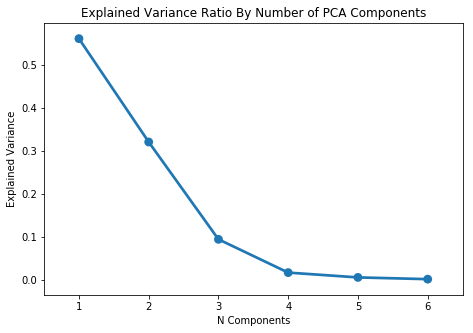

In [44]:
pca = PCA()
pca.fit(master)
plt.figure(figsize=(7.5, 5))
plt.title('Explained Variance Ratio By Number of PCA Components')
plt.ylabel('Explained Variance')
plt.xlabel('N Components')
sns.pointplot(x=np.arange(1, master.shape[1] + 1), y=pca.explained_variance_ratio_, lw=1)
plt.show()

In [45]:
master = pd.DataFrame(PCA(n_components=4).fit_transform(master), columns=['c1', 'c2', 'c3', 'c4'], index=master.index)

In [46]:
def km_intertia(df, n_clusters):
    inertias = []
    temp_df = pd.DataFrame()
    for n in n_clusters:
        model = KMeans(n_clusters=n, random_state=10).fit(df)
        model_predictions = model.predict(df)
        inertias.append(model.inertia_)
        temp_df['{0} clusters'.format(n)] = pd.Series(model_predictions, name='km{0}'.format(n), index=df.index)
    plt.figure(figsize=(7.5, 5))
    plt.title('Cluster Inertia at N Clusters')
    plt.ylabel('Inertia')
    plt.xlabel('N Clusters')
    sns.pointplot(x=np.arange(1, 7), y=inertias, lw=1)
    return pd.concat([temp_df, df], axis=1)


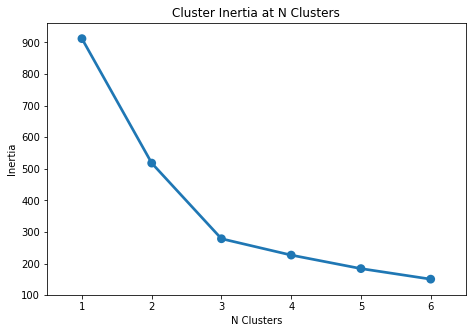

In [47]:
kms = km_intertia(master, np.arange(1, 7))


In [48]:

def silhouette_plots(df, cluster_counts, feat_names):
    for n_clusters in cluster_counts:
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 7)
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.2, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(df[feat_names]) + (n_clusters + 1) * 10])
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        cluster_labels = kms['{0} clusters'.format(n_clusters)]
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(df[feat_names], cluster_labels)
        print('At {0} clusters the mean silhouette score is {1}'.format(n_clusters, round(silhouette_avg, 4)))
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df[feat_names], cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        ax.set_xlabel('The silhouette coefficient values')
        ax.set_ylabel('Cluster label')
        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color='red', linestyle='--')
        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.title('Silhouette analysis for {0} clusters'.format(n_clusters))
        plt.show()

## Examining our clusters

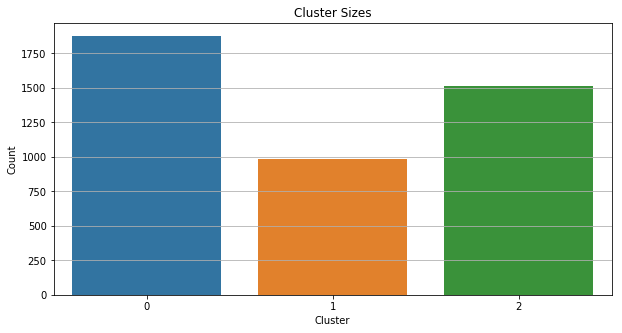

In [49]:

counts = kms['3 clusters'].value_counts().reset_index()
counts.rename({'3 clusters': 'Count', 'index': 'Cluster'}, axis=1, inplace=True)
plt.figure(figsize=(10, 5))
plt.title('Cluster Sizes')
plt.grid()
sns.barplot(x='Cluster', y='Count', data=counts)

### Cluster 0 is our largest cluster, representing 42.9% of our customers. Cluster 1 makes up 34.6% of the population and Cluster 2 is the smallest at 22.5%

In [50]:
temp_df = df.drop_duplicates('CustomerID').set_index('CustomerID').sort_index()
temp_df['Domestic'] = temp_df['Country'].where(temp_df['Country'] == 'United Kingdom', 'International')
temp_df['Domestic'] = temp_df['Domestic'].where(temp_df['Domestic'] == 'International', 'Domestic')
master = pd.concat([master_original, kms['3 clusters'], temp_df['Domestic']], axis=1)
master.rename({'3 clusters': 'Cluster'}, axis=1, inplace=True)
meanprops_dict = {'markerfacecolor': 'firebrick', 'marker': 'D', 'markeredgecolor': 'black'}

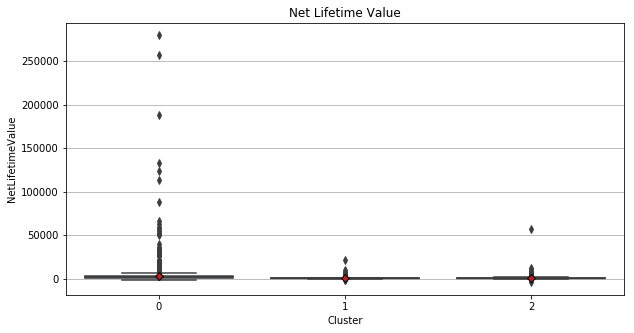

In [51]:
plt.figure(figsize=(10, 5))
plt.title('Net Lifetime Value')
plt.grid()
sns.boxplot(data=master, x='Cluster', y='NetLifetimeValue', showmeans=True, 
            meanprops=meanprops_dict)

##### We have significantly skewed distributions for our clusters. We'll filter outliers out and look at the prinicple spread, though it's also pretty clear that the big money makers are in Cluster 0. It makes sense to see that relatively few accounts bring in the most cash while the majority are middle of the road - the famous "80/20 rule".

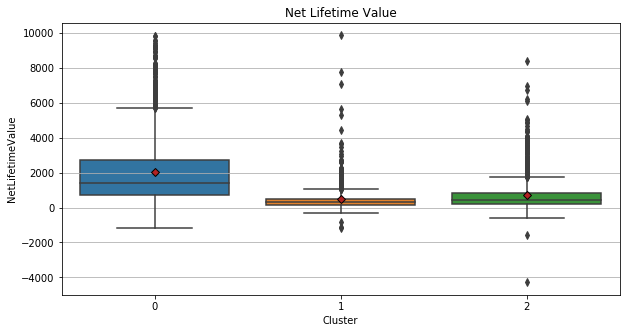

In [52]:
plt.figure(figsize=(10, 5))
plt.title('Net Lifetime Value')
plt.grid()
sns.boxplot(data=master[master['NetLifetimeValue'] < 10000], x='Cluster', y='NetLifetimeValue', 
            showmeans=True, meanprops=meanprops_dict)

##### It's clear that the most profitable accounts are in Cluster 0. Both the mean and median values of the distribution are well above 1000, and the distribution is substantially higher than the other 2 clusters. There are outliers of significant financial value in all three clusters, but the previous plot is pretty clear where the most important accounts are. I'm also curious what sets Clusters 1 and 3 apart; I presume we'll find the answer among the frequency and recency questions. Next we'll consider the mean transaction net value for the customers in each cluster.

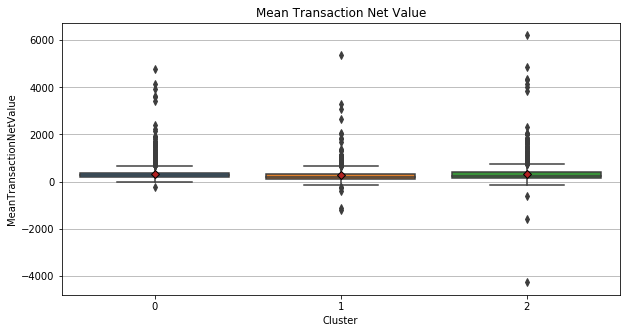

In [53]:

plt.figure(figsize=(10, 5))
plt.title('Mean Transaction Net Value')
plt.grid()
sns.boxplot(data=master, x='Cluster', y='MeanTransactionNetValue', 
            showmeans=True, meanprops=meanprops_dict)

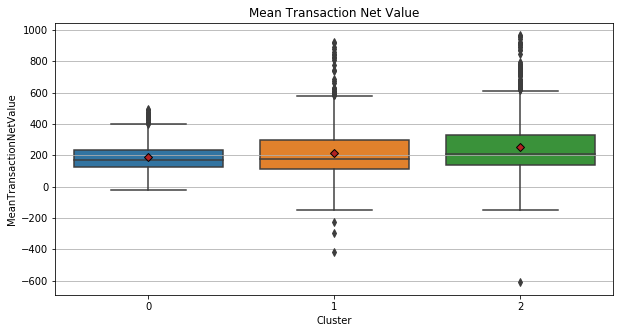

In [54]:
plt.figure(figsize=(10, 5))
plt.title('Mean Transaction Net Value')
plt.grid()
sns.boxplot(data=master[(master['NetLifetimeValue'] < 1000) & (master['NetLifetimeValue'] > -1000)], 
            x='Cluster', y='MeanTransactionNetValue', showmeans=True, meanprops=meanprops_dict)

#### The spread for each cluster is generally centered in the same area, with both means and medians centered at the 200 mark, and still skewed. The distributions for Clusters 1 and 3 dip further into negative territory than Cluster 0. Our positive outliers seen in all 3 groups tell me that the vast majority of customers are making transactions of about the same value.I presume the disparity between net lifetime value and mean transaction net value has to do with the number of transactions made by each cluster, so that's where we'll look next.

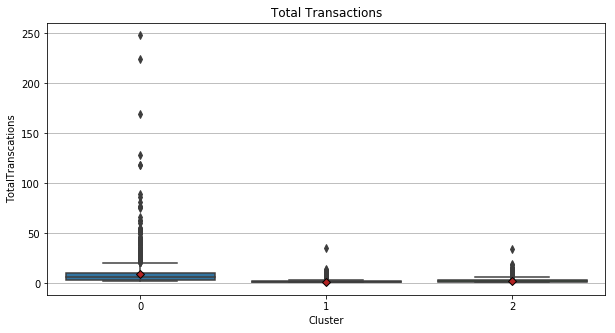

In [55]:
plt.figure(figsize=(10, 5))
plt.title('Total Transactions')
plt.grid()
sns.boxplot(data=master, x='Cluster', y='TotalTranscations', showmeans=True, 
            meanprops=meanprops_dict)

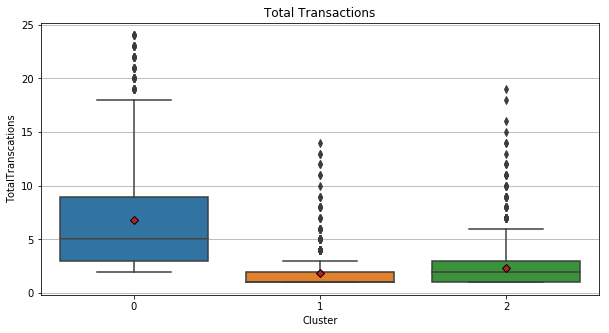

In [56]:
plt.figure(figsize=(10, 5))
plt.title('Total Transactions')
plt.grid()
sns.boxplot(data=master[master['TotalTranscations'] < 25], x='Cluster', y='TotalTranscations', 
            showmeans=True, meanprops=meanprops_dict)

#### This plot is very telling. Cluster 0 is unequivocally making up most day to day transactions, while the other two clusters once again have a similar presentation. Now we'll look at frequency and recency, which hopefully will start to tell us more about Clusters 1 and 2, which so far have looked mostly alike.

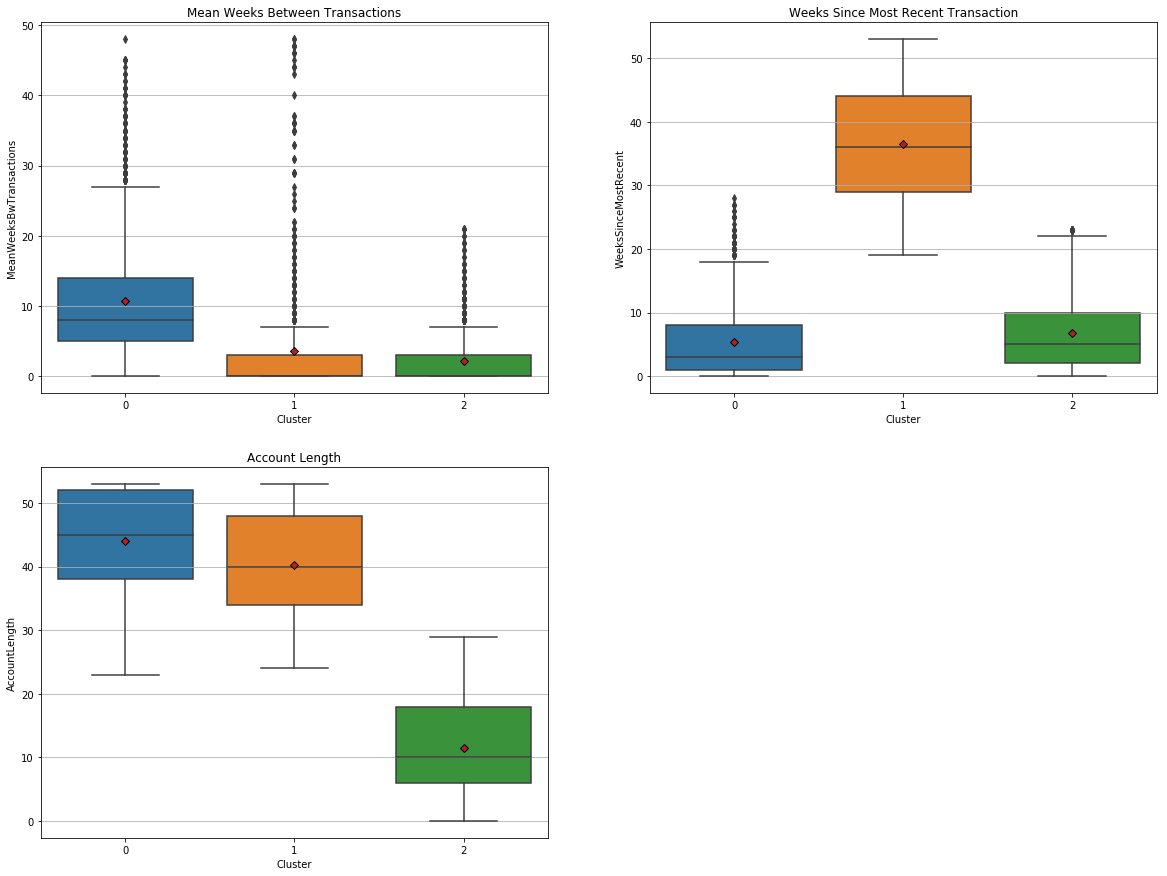

In [57]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.title('Mean Weeks Between Transactions')
plt.grid()
sns.boxplot(data=master, x='Cluster', y='MeanWeeksBwTransactions', showmeans=True, 
            meanprops=meanprops_dict)
plt.subplot(2, 2, 2)
plt.title('Weeks Since Most Recent Transaction')
plt.grid()
sns.boxplot(data=master, x='Cluster', y='WeeksSinceMostRecent', showmeans=True, 
            meanprops=meanprops_dict)
plt.subplot(2, 2, 3)
plt.title('Account Length')
plt.grid()
sns.boxplot(data=master, x='Cluster', y='AccountLength', showmeans=True, 
            meanprops=meanprops_dict)

#### It looks like Cluster 2 are newer accounts, and thus aren't represented well with total transactions and net value; their account lengths are much shorter than the other two clusters. They also compare favorably with Cluster 0 in terms of recency, having relatively similar distributions. It also appears that Cluster 1 represents accounts of lesser value: they have low lifetime value and not many total transactions, yet have long relationships with the company. They also are not representing present business, far behind the other two clusters regarding time since last transaction. The only curiosity is that the Cluster 0 spread is more infrequent that the other clusters. I put this down to it being the largest segment, including with it the most variation. I don't think this is of particular importance, especially when you consider their strong financial value and consistency. One more thing to consider is location: we didn't include geography into our clustering.

# Implications
## Cluster 0: Consistent and Loyal
#### This is your cash cow segment. These are prime accounts that offer consistent business, and includes the extremely large and valuable accounts. Those accounts are given to your best and most experienced account managers, while the others fill out books of business alongside relationships in need of development.

## Cluster 1: Limited Present Value 
#### Of all three clusters, customers in this group have the lowest mean lifetime value and the greatest mean time since their last transaction, all while being long-time customers. Relationships with this segment are fairly inert, and I believe these are the accounts that probably have a greater share of wallet to be won, and deserve some renewed attention from the sales team.

## Cluster 2: New Potential
#### As a population, these customers have low average lifetime value, but a short history with the company, and as a group they have a strong showing of recent transaction activity. These are promising young relationships that have the potential to mature into high value accounts. I would love to have actual customer information to expand our analysis. This is a B2B company we're examining, so information like customer budgets or their industry ould be very useful to dig deepr. The last task remaining is to train a classifier in order to predict which of our 3 segments other customers of ours may belong to.